In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

In [177]:
df = pd.read_csv("modified.csv")

In [178]:
df.shape

(315, 7)

In [179]:
df.head()
# all_faces/0001ca9b9a--61aa90111e37d6183d870ea5_ID_2.jpg
# "all_faces/0001cc1e1e--61af8513667cba1b47349869_Selfie_6.jpg"
#df['NewPath'] = "all_faces/"+df["SetId"]+"_"+df["FName"] OLD

,SetId,UserRace,Age,Name,FName,URL,NewPath
0,0001cc1e1e--61af8513667cba1b47349869,Hispanic,25,Weslley,ID_1.jpg,0001cc1e1e--61af8513667cba1b47349869_age_25_na...,all_faces/0001cc1e1e--61af8513667cba1b47349869...
1,0001cc1e1e--61af8513667cba1b47349869,Hispanic,25,Weslley,ID_2.jpg,0001cc1e1e--61af8513667cba1b47349869_age_25_na...,all_faces/0001cc1e1e--61af8513667cba1b47349869...
2,0001cc1e1e--61af8513667cba1b47349869,Hispanic,25,Weslley,Selfie_1.jpg,0001cc1e1e--61af8513667cba1b47349869_age_25_na...,all_faces/0001cc1e1e--61af8513667cba1b47349869...
3,0001cc1e1e--61af8513667cba1b47349869,Hispanic,25,Weslley,Selfie_10.jpg,0001cc1e1e--61af8513667cba1b47349869_age_25_na...,all_faces/0001cc1e1e--61af8513667cba1b47349869...
4,0001cc1e1e--61af8513667cba1b47349869,Hispanic,25,Weslley,Selfie_11.jpg,0001cc1e1e--61af8513667cba1b47349869_age_25_na...,all_faces/0001cc1e1e--61af8513667cba1b47349869...


In [180]:
df['Name'].value_counts()

Name
Weslley       15
Juliana       15
Rayanne       15
Fernanda      15
Daiane        15
Alejandra     15
Bruno         15
Gabriel       15
Clarissa      15
Paolo         15
Miia          15
Klara         15
Diego         15
Ewa           15
Anna          15
Kateryna      15
Mykhailo      15
Vitalijs      15
Alessandro    15
Mark          15
Kasia         15
Name: count, dtype: int64

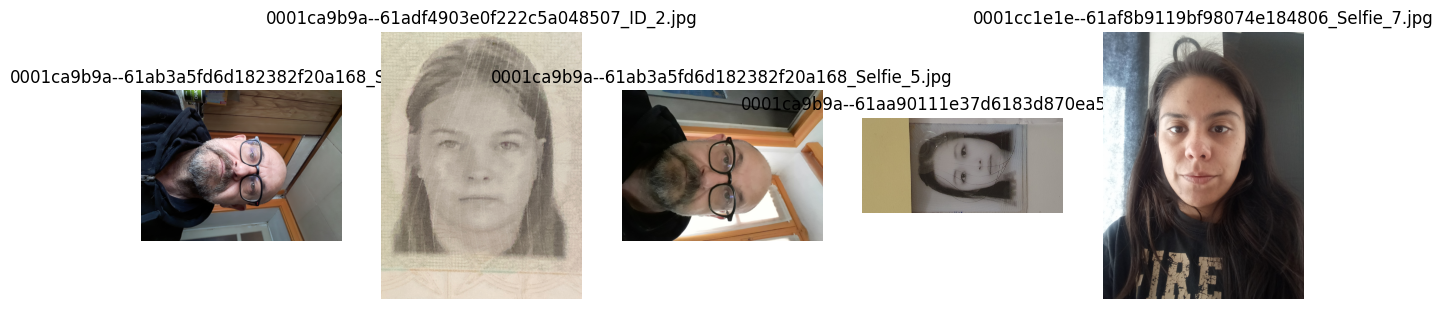

In [181]:
sample_paths = df["NewPath"].sample(5).tolist()  # Pick 5 random images
# Display the images
fig, axes = plt.subplots(1, len(sample_paths), figsize=(15, 5))

for ax, img_path in zip(axes, sample_paths):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(img_path.split("/")[-1])  # Show filename

plt.show()

In [182]:
import tensorflow as tf
# Check if TensorFlow is built with GPU support
print("TensorFlow version:", tf.__version__)
# List available devices
devices = tf.config.list_physical_devices()
print(devices)

# Try listing GPUs
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print("GPUs detected:", gpus)
else:
    print("No GPUs detected.")

TensorFlow version: 2.19.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
No GPUs detected.


In [183]:
# Using Facenet to Embed Images into Vectors
from keras_facenet import FaceNet

# Load the pre-trained FaceNet model
embedder = FaceNet()


In [184]:
# Extracting the Face Embeddings
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from mtcnn import MTCNN
from PIL import Image, ImageOps
import numpy as np

detector = MTCNN()

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")
    img = img.resize((160, 160))  # Resize for FaceNet
    img_array = np.asarray(img) / 255.0  # Normalize
    return np.expand_dims(img_array, axis=0)


def extract_face(image_path):
    img = Image.open(image_path)
    img = ImageOps.exif_transpose(img)  # Fix image rotation
    img = img.convert("RGB")
    img_array = np.asarray(img)

    detections = detector.detect_faces(img_array)
    if len(detections) == 0:
        return None  # No face found

    x, y, w, h = detections[0]["box"]
    face = img_array[y:y+h, x:x+w]
    face = Image.fromarray(face)
    face = face.resize((160, 160))
    
    face_array = np.asarray(face) / 255.0  # Normalize
    return np.expand_dims(face_array, axis=0)

In [185]:
def get_embeddings(image_paths):
    embeddings = []
    no_face_detected = []
    valid_indices = []  
    count = 0
    total_images = len(image_paths)

    for idx, path in enumerate(image_paths):
        count += 1
        try:
            # Extract face
            face = extract_face(path)
            if face is None:
                print(f"Skipping {path} (No face detected)")
                no_face_detected.append(path)
                continue

            # Important change: Get embedding and make sure we're getting unique embeddings
            embedding = embedder.embeddings(face)[0]  # This should give a 512-dim vector
            
            # Print a sample of values to verify they're unique
            if count % 50 == 0:
                print(f"Sample embedding values: {embedding[:5]}")
            
            embeddings.append(embedding)
            valid_indices.append(idx)
            
            print(f"Processed {count}/{total_images}")
        except Exception as e:
            print(f"Error processing {path}: {e}")
            no_face_detected.append(path)

    return embeddings, no_face_detected, valid_indices

# Apply to dataset
X, no_face_images, valid_indices = get_embeddings(df["NewPath"].tolist())
y = df["Name"].values  # Labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processed 1/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Processed 2/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Processed 3/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Processed 4/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Processed 5/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Processed 6/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Processed 7/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Processed 8/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Processed 9/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Processed 10/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Processed 11/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Processed 12/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Processed 13/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Processed 14/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Processed 15/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Processed 16/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Processed 17/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Processed 18/315
1/1 ━━━━━━━━━━━━━━━━━

# Embedding the Images (WARNING: This Next portion is CPU Intensive)
- It took my personal computer 35ish minutes

In [189]:
import cv2

def get_embeddings(image_paths):
    embeddings = []
    no_face_detected = []
    valid_indices = []  
    count = 0
    total_images = len(image_paths)

    for idx, path in enumerate(image_paths):
        count += 1
        try:
            # Load image directly (no preprocessing needed)
            img = cv2.imread(path)
            if img is None:
                print(f"Couldn't read image {path}")
                no_face_detected.append(path)
                continue
                
            # Convert from BGR to RGB (OpenCV loads as BGR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Use FaceNet's built-in extraction function
            detections = embedder.extract(img, threshold=0.95)
            
            if not detections:
                print(f"No faces detected in {path}")
                no_face_detected.append(path)
                continue
                
            # Get embedding from the first face detected
            embedding = detections[0]['embedding']
            
            # Print sample values for debugging
            if count <= 5 or count % 50 == 0:
                print(f"Image {path.split('/')[-1]}")
                print(f"Sample embedding values: {embedding[:5]}")
                if count > 1:
                    # Check similarity with previous embedding
                    prev_emb = embeddings[-1]
                    similarity = np.dot(embedding, prev_emb) / (np.linalg.norm(embedding) * np.linalg.norm(prev_emb))
                    print(f"Similarity with previous embedding: {similarity}")
            
            embeddings.append(embedding)
            valid_indices.append(idx)
            
            print(f"Processed {count}/{total_images}")
        except Exception as e:
            print(f"Error processing {path}: {str(e)}")
            no_face_detected.append(path)

    return embeddings, no_face_detected, valid_indices

# Apply to dataset
X, no_face_images, valid_indices = get_embeddings(df["NewPath"].tolist())
y = df["Name"].values  # Labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Image 0001cc1e1e--61af8513667cba1b47349869_ID_1.jpg
Sample embedding values: [0.05464899 0.10810396 0.04658166 0.04633976 0.00977947]
Processed 1/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Image 0001cc1e1e--61af8513667cba1b47349869_ID_2.jpg
Sample embedding values: [0.02704338 0.09648998 0.02009863 0.02123786 0.01127489]
Similarity with previous embedding: 0.7368221879005432
Processed 2/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Image 0001cc1e1e--61af8513667cba1b47349869_Selfie_1.jpg
Sample embedding values: [ 0.05540827  0.09140854  0.01177645  0.04548834 -0.02524862]
Similarity with previous embedding: 0.8472779393196106
Processed 3/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Image 0001cc1e1e--61af8513667cba1b47349869_Selfie_10.jpg
Sample embedding values: [ 0.07088608  0.06916077  0.03336617  0.03477383 -0.02799136]
Similarity with previous embedding: 0.8917578458786011
Processed 4/315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Image 0001cc1e1e--61af851

In [190]:
df['Embedding'] = None

for idx, modidx in enumerate(valid_indices): #maps the embeddings to the correct indexes
    df.at[modidx, 'Embedding'] = X[idx]

print("DONE")

DONE


In [191]:
df.sample(5)['Embedding']

92     [0.05606028, 0.04707095, -0.016309885, 0.07173...
99     [0.082757376, 0.0789527, -0.022242444, 0.07071...
123    [0.01744977, -0.030779269, -0.07947809, -0.041...
59     [-0.055791013, 0.034323618, -0.053427637, -0.0...
77     [0.041579258, -0.049782336, 0.028173737, 0.009...
Name: Embedding, dtype: object

In [192]:
df['Embedding'].isna().sum()

np.int64(11)

Number of no_face_images = 11


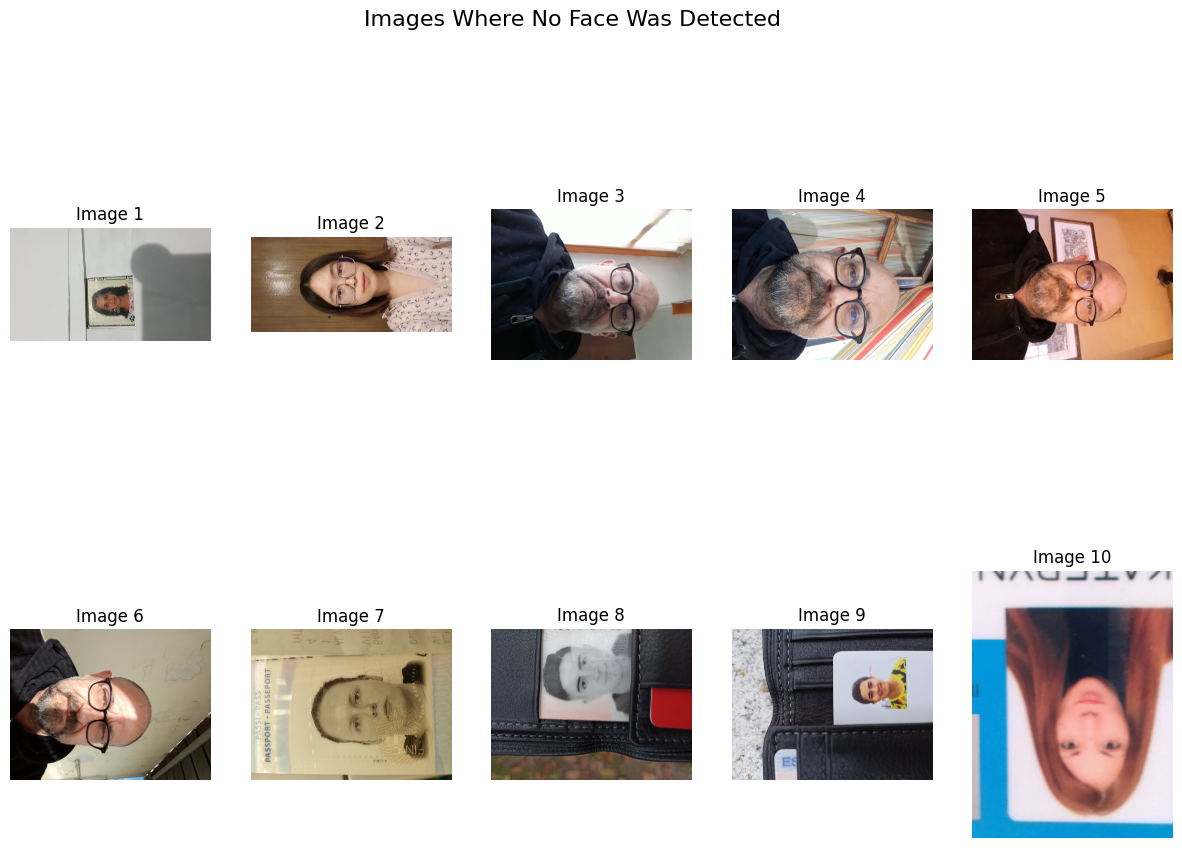

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

print(f"Number of no_face_images = {len(no_face_images)}")
# Show up to 10 images that had no detected faces
num_images = min(10, len(no_face_images))  # Limit to 10 images

plt.figure(figsize=(15, 10))  # Set figure size

for i in range(num_images):
    img_path = no_face_images[i]
    img = Image.open(img_path)
    img = ImageOps.exif_transpose(img) #Fixes (most) rotation issues

    plt.subplot(2, 5, i + 1)  # Create a 2-row grid (max 10 images)
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.title(f"Image {i+1}")

plt.suptitle("Images Where No Face Was Detected", fontsize=16)
plt.show()


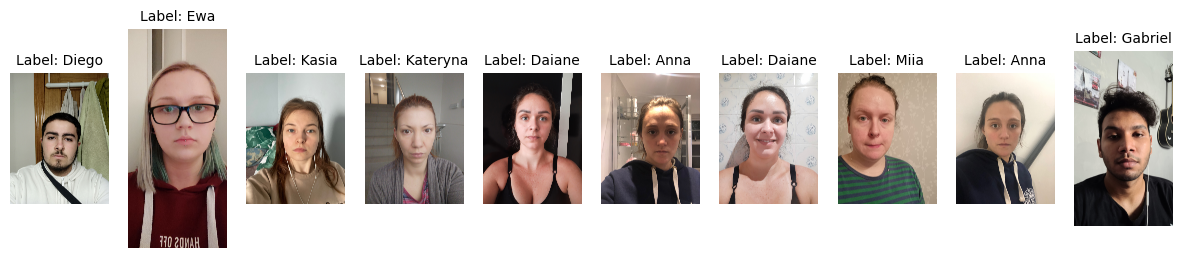

In [158]:
import matplotlib.pyplot as plt
import random

def show_random_faces(df, num_samples=5):
    """Randomly selects and displays images with labels."""
    sample_indices = random.sample(range(len(df)), min(num_samples, len(df)))  # Ensure valid indices

    fig, axes = plt.subplots(1, len(sample_indices), figsize=(15, 5))  # Create subplot
    if len(sample_indices) == 1:
        axes = [axes]  # Ensure iterable for single image case

    for i, idx in enumerate(sample_indices):
        img_path = df.iloc[idx]["NewPath"]
        label = df.iloc[idx]["Name"]

        img = Image.open(img_path)  # Load image
        img = ImageOps.exif_transpose(img) 

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}", fontsize=10)
        axes[i].axis("off")

    plt.show()

# Show 5 random faces with labels
show_random_faces(df, num_samples=10)


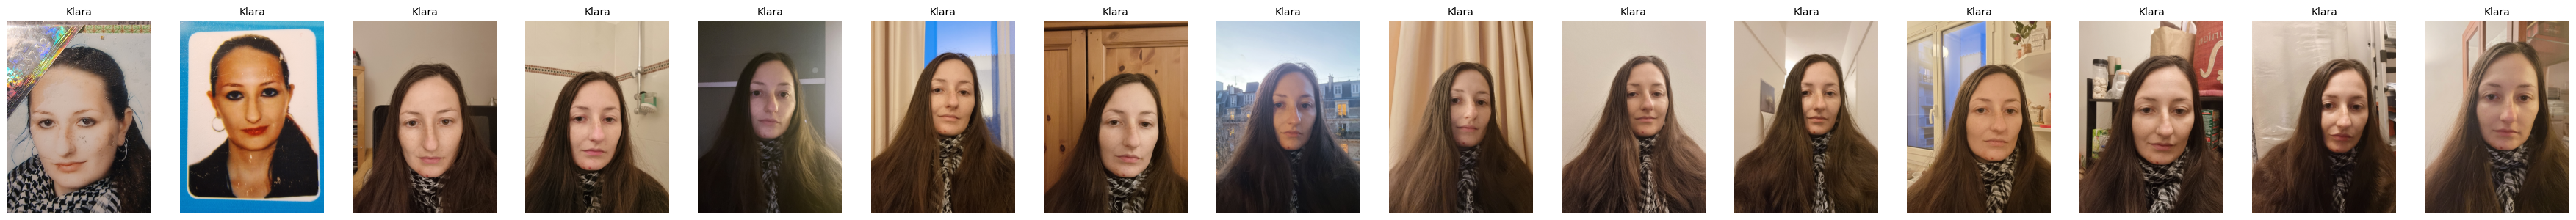

In [40]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

def show_faces_by_name(df, person_name):
    """Displays all images of a person with a given name."""
    person_df = df[df["Name"] == person_name]  # Filter dataset for the given name
    num_images = len(person_df)

    if num_images == 0:
        print(f"No images found for {person_name}.")
        return

    fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 5))  # Create subplots
    if num_images == 1:
        axes = [axes]  # Ensure iterable for single image case

    for i, (_, row) in enumerate(person_df.iterrows()):
        img_path = row["NewPath"]
        img = Image.open(img_path)  # Load image
        img = ImageOps.exif_transpose(img)  # Fix rotation

        axes[i].imshow(img)
        axes[i].set_title(f"{person_name}", fontsize=10)
        axes[i].axis("off")

    plt.show()

# Example: Show all images of "Name"
show_faces_by_name(df, "Klara")


In [196]:
df.dropna(subset=['Embedding'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(304, 8)

# Modeling Setup

In [206]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

y = df["Name"].values 

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train = np.array(X_train)

# Get original names for better reporting
y_train_names = le.inverse_transform(y_train)
y_test_names = le.inverse_transform(y_test)


# SVM Setup

In [207]:

# 1. SVM Classification
print("===== SVM Classifier =====")
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Test SVM
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

# Show some example predictions
print("\nSVM Example Predictions:")
for i in range(5):
    true_name = le.inverse_transform([y_test[i]])[0]
    pred_name = le.inverse_transform([y_pred_svm[i]])[0]
    proba = svm_model.predict_proba([X_test[i]])[0]
    confidence = proba[y_pred_svm[i]]
    print(f"True: {true_name:10} | Predicted: {pred_name:10} | Confidence: {confidence:.4f}")


===== SVM Classifier =====
SVM Accuracy: 0.9836
              precision    recall  f1-score   support

   Alejandra       1.00      1.00      1.00         3
  Alessandro       1.00      1.00      1.00         3
        Anna       0.75      1.00      0.86         3
       Bruno       1.00      0.67      0.80         3
    Clarissa       1.00      1.00      1.00         3
      Daiane       1.00      1.00      1.00         3
       Diego       1.00      1.00      1.00         2
         Ewa       1.00      1.00      1.00         3
    Fernanda       1.00      1.00      1.00         3
     Gabriel       1.00      1.00      1.00         3
     Juliana       1.00      1.00      1.00         3
       Kasia       1.00      1.00      1.00         3
    Kateryna       1.00      1.00      1.00         3
       Klara       1.00      1.00      1.00         3
        Mark       1.00      1.00      1.00         3
        Miia       1.00      1.00      1.00         3
    Mykhailo       1.00      1.00

# Distance Based Classification

In [208]:

# 2. Distance-based verification
print("\n===== Distance-based Verification =====")

# Create reference embeddings per person
reference_embeddings = {}
for name in le.classes_:
    name_idx = np.where(y_train_names == name)[0]
    reference_embeddings[name] = X_train[np.array(name_idx, dtype=int)]


# Test distance-based approach
correct_count = 0
print("Distance-based Example Predictions:")
for i in range(5):
    embedding = X_test[i]
    true_name = le.inverse_transform([y_test[i]])[0]
    
    # Calculate similarity to each class
    similarities = {}
    for name, refs in reference_embeddings.items():
        # Calculate cosine similarities
        sims = cosine_similarity([embedding], refs)[0]
        similarities[name] = np.mean(sims)
    
    # Get predicted name (highest similarity)
    pred_name = max(similarities, key=similarities.get)
    confidence = similarities[pred_name]
    true_sim = similarities[true_name]
    
    if pred_name == true_name:
        correct_count += 1
        
    print(f"True: {true_name:10} | Predicted: {pred_name:10} | Similarity: {confidence:.4f} | True similarity: {true_sim:.4f}")

# Calculate overall distance-based accuracy
y_pred_dist = []
for i in range(len(X_test)):
    embedding = X_test[i]
    similarities = {name: np.mean(cosine_similarity([embedding], refs)[0]) 
                   for name, refs in reference_embeddings.items()}
    pred_name = max(similarities, key=similarities.get)
    y_pred_dist.append(le.transform([pred_name])[0])

accuracy_dist = accuracy_score(y_test, y_pred_dist)
print(f"\nDistance-based Accuracy: {accuracy_dist:.4f}")
print(classification_report(y_test, y_pred_dist, target_names=le.classes_))



===== Distance-based Verification =====
Distance-based Example Predictions:
True: Weslley    | Predicted: Weslley    | Similarity: 0.8865 | True similarity: 0.8865
True: Paolo      | Predicted: Paolo      | Similarity: 0.6964 | True similarity: 0.6964
True: Kateryna   | Predicted: Kateryna   | Similarity: 0.8988 | True similarity: 0.8988
True: Miia       | Predicted: Miia       | Similarity: 0.5301 | True similarity: 0.5301
True: Weslley    | Predicted: Weslley    | Similarity: 0.8626 | True similarity: 0.8626

Distance-based Accuracy: 0.9836
              precision    recall  f1-score   support

   Alejandra       1.00      1.00      1.00         3
  Alessandro       1.00      1.00      1.00         3
        Anna       0.75      1.00      0.86         3
       Bruno       1.00      0.67      0.80         3
    Clarissa       1.00      1.00      1.00         3
      Daiane       1.00      1.00      1.00         3
       Diego       1.00      1.00      1.00         2
         Ewa     

# KNN Model

In [209]:

# 3. K-Nearest Neighbors (another good approach for face recognition)
print("\n===== KNN Classifier =====")
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.4f}")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))



===== KNN Classifier =====
KNN Accuracy: 0.9836
              precision    recall  f1-score   support

   Alejandra       1.00      1.00      1.00         3
  Alessandro       1.00      1.00      1.00         3
        Anna       0.75      1.00      0.86         3
       Bruno       1.00      0.67      0.80         3
    Clarissa       1.00      1.00      1.00         3
      Daiane       1.00      1.00      1.00         3
       Diego       1.00      1.00      1.00         2
         Ewa       1.00      1.00      1.00         3
    Fernanda       1.00      1.00      1.00         3
     Gabriel       1.00      1.00      1.00         3
     Juliana       1.00      1.00      1.00         3
       Kasia       1.00      1.00      1.00         3
    Kateryna       1.00      1.00      1.00         3
       Klara       1.00      1.00      1.00         3
        Mark       1.00      1.00      1.00         3
        Miia       1.00      1.00      1.00         3
    Mykhailo       1.00      1.0

# Threshold-based Verification

In [210]:
# 4. Threshold-based verification (this is how face recognition typically works)
print("\n===== Threshold-based Verification =====")

# Calculate thresholds
genuine_scores = []
impostor_scores = []

for i, embedding in enumerate(X_test):
    true_name = le.inverse_transform([y_test[i]])[0]
    
    for name, refs in reference_embeddings.items():
        sims = cosine_similarity([embedding], refs)[0]
        avg_sim = np.mean(sims)
        
        if name == true_name:
            genuine_scores.append(avg_sim)
        else:
            impostor_scores.append(avg_sim)

# Find the threshold that maximizes accuracy
thresholds = np.linspace(0, 1, 100)
best_threshold = 0
best_accuracy = 0

for threshold in thresholds:
    # Calculate acceptance rates
    genuine_accept = np.mean(np.array(genuine_scores) >= threshold)
    impostor_reject = np.mean(np.array(impostor_scores) < threshold)
    accuracy = (genuine_accept + impostor_reject) / 2
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Best verification threshold: {best_threshold:.4f}")
print(f"Expected verification accuracy: {best_accuracy:.4f}")



===== Threshold-based Verification =====
Best verification threshold: 0.4444
Expected verification accuracy: 0.9898


# Plotting Distribution Scores

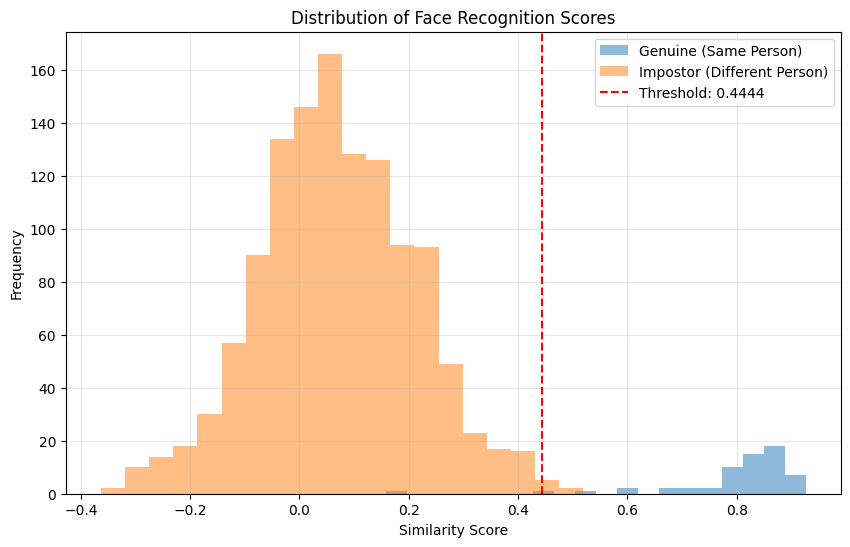

In [ ]:
# This is by Threshold-based Verification
# Plot score distributions
plt.figure(figsize=(10, 6))
plt.hist(genuine_scores, bins=20, alpha=0.5, label='Genuine (Same Person)')
plt.hist(impostor_scores, bins=20, alpha=0.5, label='Impostor (Different Person)')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Threshold: {best_threshold:.4f}')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Face Recognition Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig('face_recognition_scores.png')
plt.close()

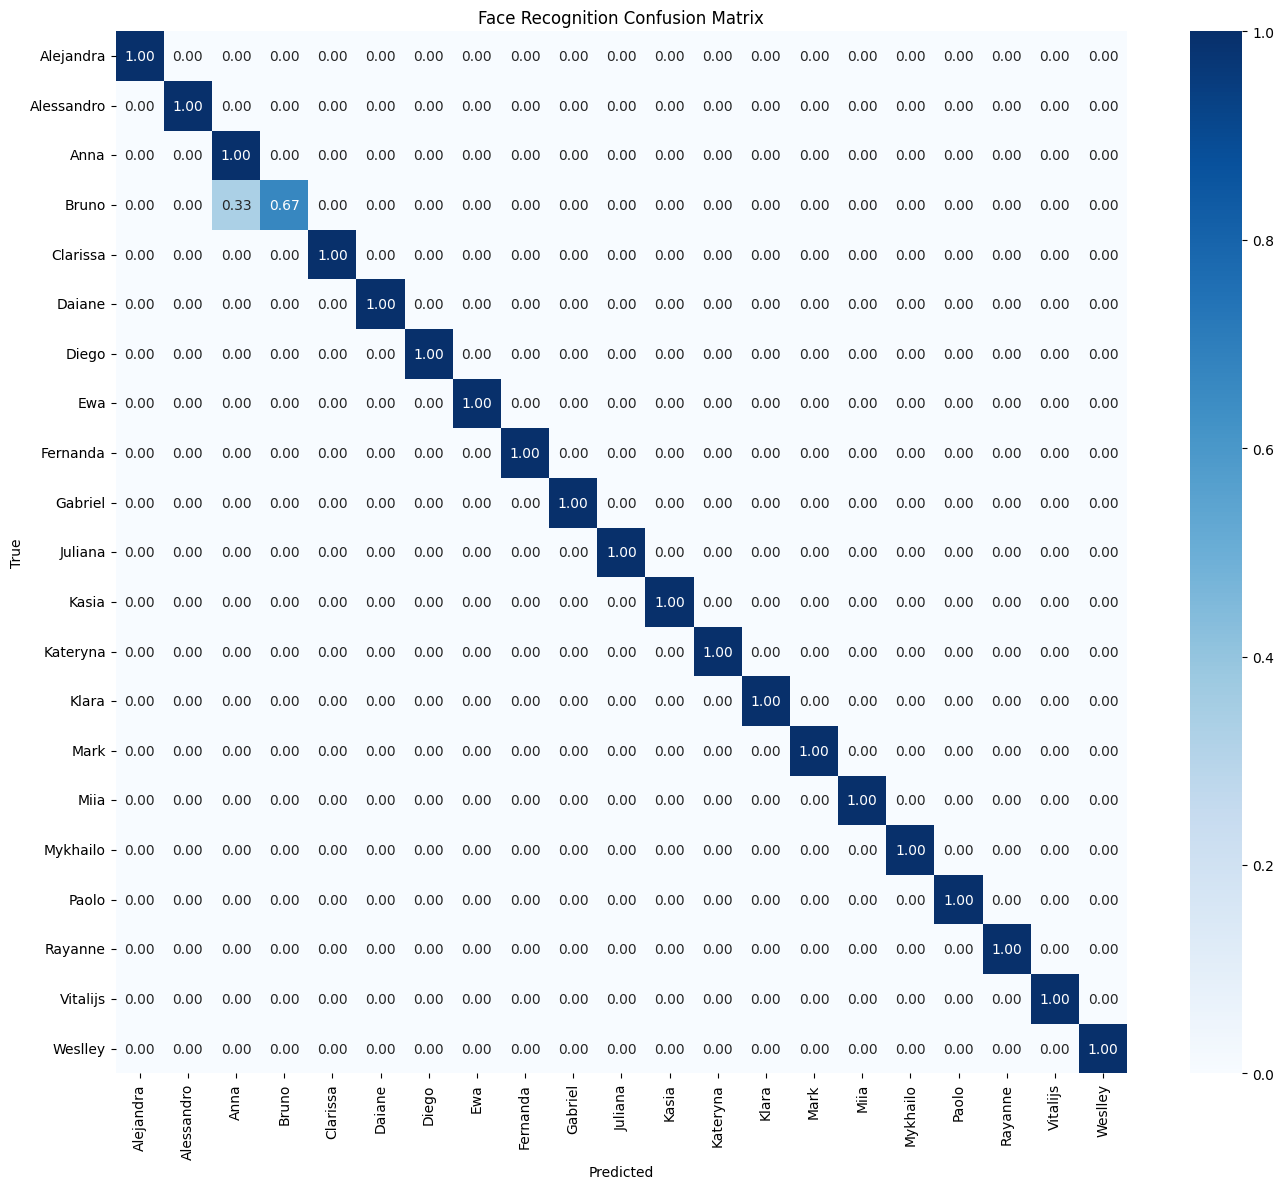

In [214]:

# 5. Create a confusion matrix to see which identities get confused
y_pred_names = le.inverse_transform(y_pred_dist)
conf_matrix = np.zeros((len(le.classes_), len(le.classes_)))

for i in range(len(y_test_names)):
    true_idx = np.where(le.classes_ == y_test_names[i])[0][0]
    pred_idx = np.where(le.classes_ == y_pred_names[i])[0][0]
    conf_matrix[true_idx, pred_idx] += 1

# Normalize confusion matrix
row_sums = conf_matrix.sum(axis=1)
conf_matrix_norm = conf_matrix / row_sums[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Face Recognition Confusion Matrix')
plt.tight_layout()
plt.show()
plt.savefig('confusion_matrix.png')
plt.close()

# t-SNE Visualization

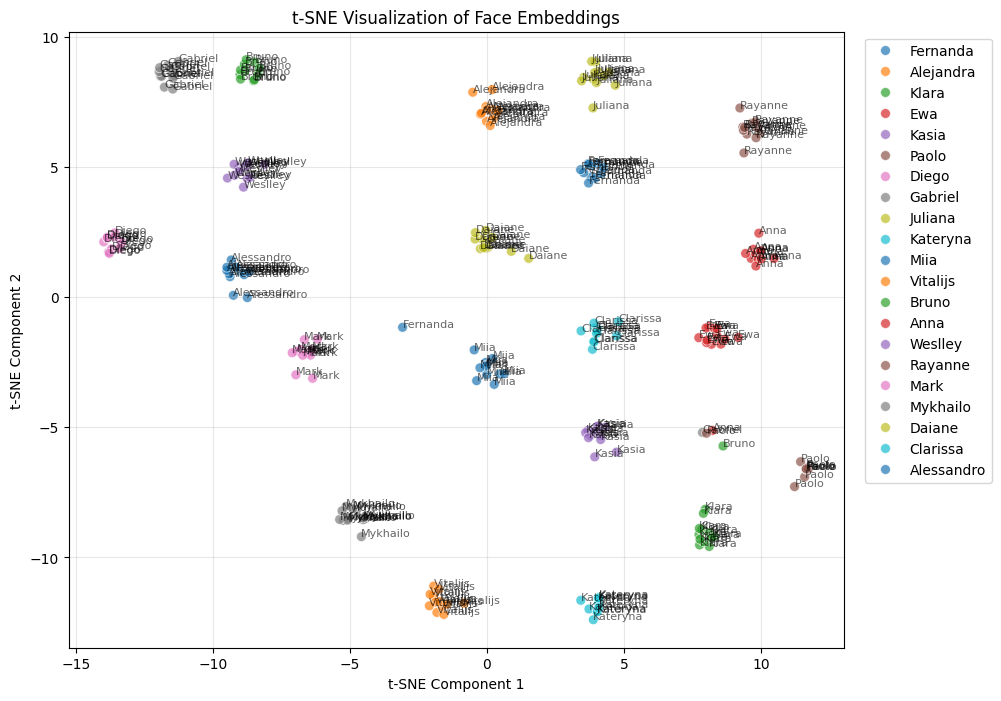

In [215]:
from sklearn.manifold import TSNE
# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_train_2D = tsne.fit_transform(X_train)

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_train_2D[:, 0], y=X_train_2D[:, 1], hue=y_train_names, palette="tab10", s=50, alpha=0.7)

# Label the points with names
for i, name in enumerate(y_train_names):
    plt.text(X_train_2D[i, 0], X_train_2D[i, 1], name, fontsize=8, alpha=0.6)

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Face Embeddings")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.grid(True, alpha=0.3)
plt.show()